In [14]:
import pandas as pd

df = pd.read_csv('./Breast_cancer_data.csv')

                 mean_radius  mean_texture  mean_perimeter  mean_area  \
mean_radius         1.000000      0.323782        0.997855   0.987357   
mean_texture        0.323782      1.000000        0.329533   0.321086   
mean_perimeter      0.997855      0.329533        1.000000   0.986507   
mean_area           0.987357      0.321086        0.986507   1.000000   
mean_smoothness     0.170581     -0.023389        0.207278   0.177028   
diagnosis          -0.730029     -0.415185       -0.742636  -0.708984   

                 mean_smoothness  diagnosis  
mean_radius             0.170581  -0.730029  
mean_texture           -0.023389  -0.415185  
mean_perimeter          0.207278  -0.742636  
mean_area               0.177028  -0.708984  
mean_smoothness         1.000000  -0.358560  
diagnosis              -0.358560   1.000000  


<AxesSubplot:>

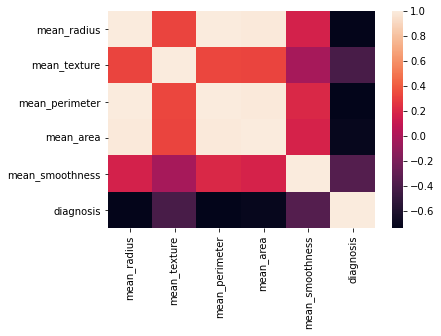

In [15]:
import seaborn as sns

print(df.corr())
sns.heatmap(df.corr())

In [16]:
df.drop(columns=['mean_perimeter', 'mean_area'], inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_smoothness  569 non-null    float64
 3   diagnosis        569 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.9 KB


In [18]:
X ,y = df.drop(columns=['diagnosis']), df['diagnosis']

In [19]:
X = (X - X.mean()) / X.std()

In [20]:
X.head()

,mean_radius,mean_texture,mean_smoothness
0,1.096100,-2.071512,1.567087
1,1.828212,-0.353322,-0.826235
2,1.578499,0.455786,0.941382
3,-0.768233,0.253509,3.280667
4,1.748758,-1.150804,0.280125


In [21]:
def train_test_split(dataset, sizes = [0.8, 0.2], shuffle = True):
    if shuffle:
        dataset = dataset.sample(frac = 1, random_state = 42).reset_index(drop=True)
    return dataset.iloc[:int(sizes[0] * len(dataset))].reset_index(drop=True), dataset.iloc[int(sizes[0] * len(dataset)):].reset_index(drop=True)

train, test = train_test_split(df)

In [22]:
X_tain, y_train = train.drop(columns=['diagnosis']), train['diagnosis']
X_test, y_test = test.drop(columns=['diagnosis']), test['diagnosis']

In [37]:
import numpy as np
from numpy.linalg import inv, det

class Model:
    def __init__(self):
        self.mu0 = self.mu1 = 0
        self.cov_matrix0 = self.cov_matrix1 = 0
        self.num_of_features = 0
        self.pw0 = self.pw1 = 0
        
    def fit(self, df):
        self.num_of_features = len(df.columns) - 1
        
        self.pw0 = len(df[df['diagnosis'] == 0]) / len(df)
        self.pw1 = len(df[df['diagnosis'] == 1]) / len(df)
        
        self.mu0 = df[df['diagnosis'] == 0].drop(columns=['diagnosis']).mean()
        self.mu1 = df[df['diagnosis'] == 1].drop(columns=['diagnosis']).mean()
        
        self.cov_matrix0 = df[df['diagnosis'] == 0].drop(columns=['diagnosis']).cov().to_numpy()
        self.cov_matrix1 = df[df['diagnosis'] == 0].drop(columns=['diagnosis']).cov().to_numpy()
        
        self.mu0 = np.reshape(np.array(self.mu0), (self.num_of_features, 1))
        self.mu1 = np.reshape(np.array(self.mu1), (self.num_of_features, 1))
        self.cov_matrix0 = np.reshape(np.array(self.cov_matrix0), (self.num_of_features, self.num_of_features))
        self.cov_matrix1 = np.reshape(np.array(self.cov_matrix1), (self.num_of_features, self.num_of_features))
        
    def g_function(self, x, mu, covariance_matrix, pw):
        return -(0.5) * (x - mu).T.dot(inv(covariance_matrix)).dot((x - mu)) + -(0.5) * np.log(det(covariance_matrix)) + np.log(pw)
        
    def predict(self, X):
        predicts = []
        for i in range(len(X)):
            x = np.reshape(np.array(X.iloc[i]), (self.num_of_features, 1))
            if (self.g_function(x, self.mu0, self.cov_matrix0, self.pw0) > self.g_function(x, self.mu1, self.cov_matrix1, self.pw1)):
                predicts.append(0)
            else:
                predicts.append(1)
        return predicts

In [38]:
model = Model()
model.fit(train)
predicts = model.predict(X_test)

In [40]:
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and predicts[i] == 1:
        TP += 1
    elif y_test.iloc[i] == 1 and predicts[i] == 0:
        FN += 1
    elif y_test.iloc[i] == 0 and predicts[i] == 1:
        FP += 1
    else:
        TN += 1

In [44]:
from texttable import Texttable

table = Texttable()
table.add_row(['Actual | Predicted', 'Positive', 'Negative'])
table.add_row(['Positive', str(TP), str(FN)])
table.add_row(['Negative', str(FP), str(TN)])
print(table.draw())

+--------------------+----------+----------+
| Actual | Predicted | Positive | Negative |
+--------------------+----------+----------+
| Positive           | 62       | 5        |
+--------------------+----------+----------+
| Negative           | 13       | 34       |
+--------------------+----------+----------+


In [45]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8421052631578947


In [49]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_tain, y_train)

predicts = model.predict(X_test)

In [52]:
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(y_test)):
    if y_test.iloc[i] == 1 and predicts[i] == 1:
        TP += 1
    elif y_test.iloc[i] == 1 and predicts[i] == 0:
        FN += 1
    elif y_test.iloc[i] == 0 and predicts[i] == 1:
        FP += 1
    else:
        TN += 1

In [53]:
table = Texttable()
table.add_row(['Actual | Predicted', 'Positive', 'Negative'])
table.add_row(['Positive', str(TP), str(FN)])
table.add_row(['Negative', str(FP), str(TN)])
print(table.draw())

+--------------------+----------+----------+
| Actual | Predicted | Positive | Negative |
+--------------------+----------+----------+
| Positive           | 62       | 5        |
+--------------------+----------+----------+
| Negative           | 12       | 35       |
+--------------------+----------+----------+


In [54]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8508771929824561
